In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Setting display options
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.max_columns', 999)

In [3]:
# Load data
df = pd.read_excel("./data/online_retail.xlsx", sheet_name=0)

In [4]:
# Initial data exploration
print("Data Head:\n", df.head(10))
print("\nData Info:\n")
df.info()
print("\nData Description (Numeric):\n", df.describe())
print("\nData Description (Object):\n", df.describe(include='O'))

Data Head:
   Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5  489434     22064           PINK DOUGHNUT TRINKET POT         24   
6  489434     21871                  SAVE THE PLANET MUG        24   
7  489434     21523   FANCY FONT HOME SWEET HOME DOORMAT        10   
8  489435     22350                            CAT BOWL         12   
9  489435     22349       DOG BOWL , CHASING BALL DESIGN        12   

          InvoiceDate                Price          Customer ID  \
0 2009-12-01 07:45:00                 6.95             13085.00   
1 2009-12-01 07:45:00                 6.75             13085.00   
2 2009-12-01 07:

In [5]:
df[df["Customer ID"].isna()].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1058,489548,22195,LARGE HEART MEASURING SPOONS,1,2009-12-01 12:32:00,1.65,NaN,United Kingdom


In [6]:
df[df["Quantity"] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321.00,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321.00,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592.00,United Kingdom


In [7]:
# Handle missing and incorrect data
df.dropna(subset=["Customer ID"], inplace=True)
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [8]:
# Filter invoices to only numeric invoice codes
df["Invoice"] = df["Invoice"].astype(str)
df = df[df["Invoice"].str.match("^\\d{6}$")]

### Notes

#### Stock Code
* StockCode is meant to follow the pattern `[0-9]{5}` but seems to have legit values for `[0-9]{5}[a-zA-Z]+`
    * Also contains other values:
        | **Code**            | **Description**                                                        | **Action**              |
        |---------------------|------------------------------------------------------------------------|-------------------------|
        | DCGS            | Looks valid, some quantities are negative though and customer ID is null | Exclude from clustering |
        | D               | Looks valid, represents discount values                                | Exclude from clustering |
        | DOT             | Looks valid, represents postage charges                                | Exclude from clustering |
        | M or m          | Looks valid, represents manual transactions                            | Exclude from clustering |
        | C2              | Carriage transaction - not sure what this means                        | Exclude from clustering |
        | C3              | Not sure, only 1 transaction                                           | Exclude                 |
        | BANK CHARGES or B | Bank charges                                                        | Exclude from clustering |
        | S               | Samples sent to customer                                               | Exclude from clustering |
        | TESTXXX         | Testing data, not valid                                                | Exclude from clustering |
        | gift__XXX       | Purchases with gift cards, might be interesting for another analysis, but no customer data | Exclude |
        | PADS            | Looks like a legit stock code for padding                              | Include                 |
        | SP1002          | Looks like a special request item, only 2 transactions, 3 look legit, 1 has 0 pricing | Exclude for now|
        | AMAZONFEE       | Looks like fees for Amazon shipping or something                       | Exclude for now         |
        | ADJUSTX         | Looks like manual account adjustments by admins                        | Exclude for now         |

In [9]:
# Clean and validate stock codes
df["StockCode"] = df["StockCode"].astype(str)
mask = (
    df["StockCode"].str.match("^\\d{5}$") |
    df["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") |
    df["StockCode"].str.match("^PADS$")
)
df = df[mask]

In [10]:
# Feature engineering
df["SalesLineTotal"] = df["Quantity"] * df["Price"]
aggregated_df = df.groupby("Customer ID", as_index=False).agg(
    MonetaryValue=("SalesLineTotal", "sum"),
    Frequency=("Invoice", "nunique"),
    LastInvoiceDate=("InvoiceDate", "max")
)

In [11]:
# Calculate Recency
max_invoice_date = aggregated_df["LastInvoiceDate"].max()
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days
# aggregated_df.drop(columns="LastInvoiceDate", inplace=True)

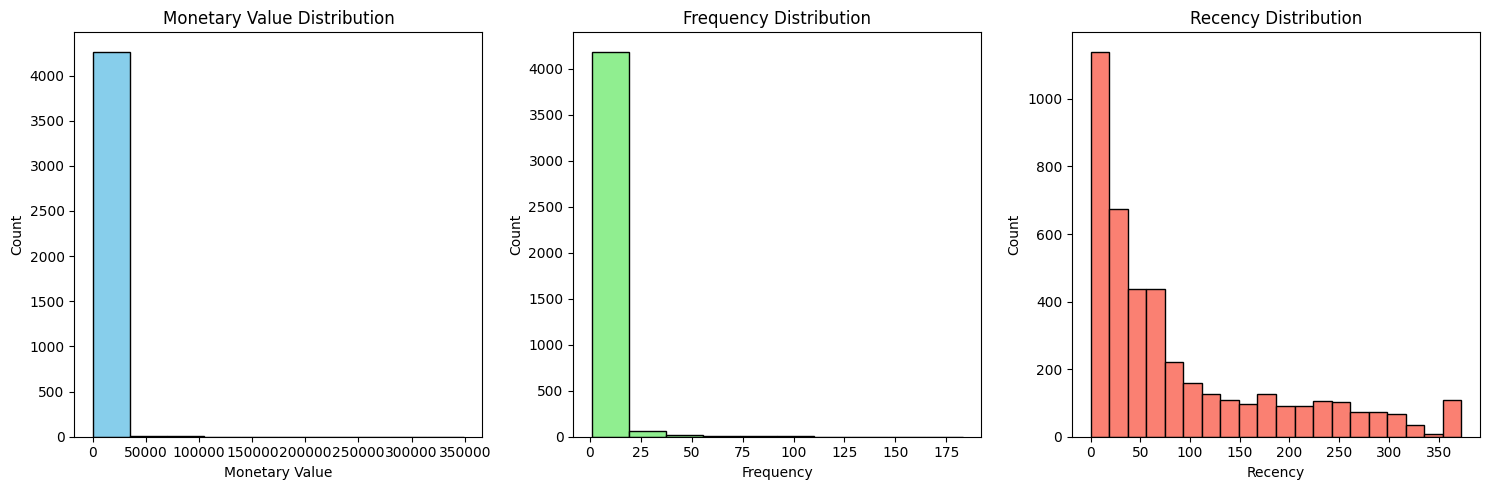

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

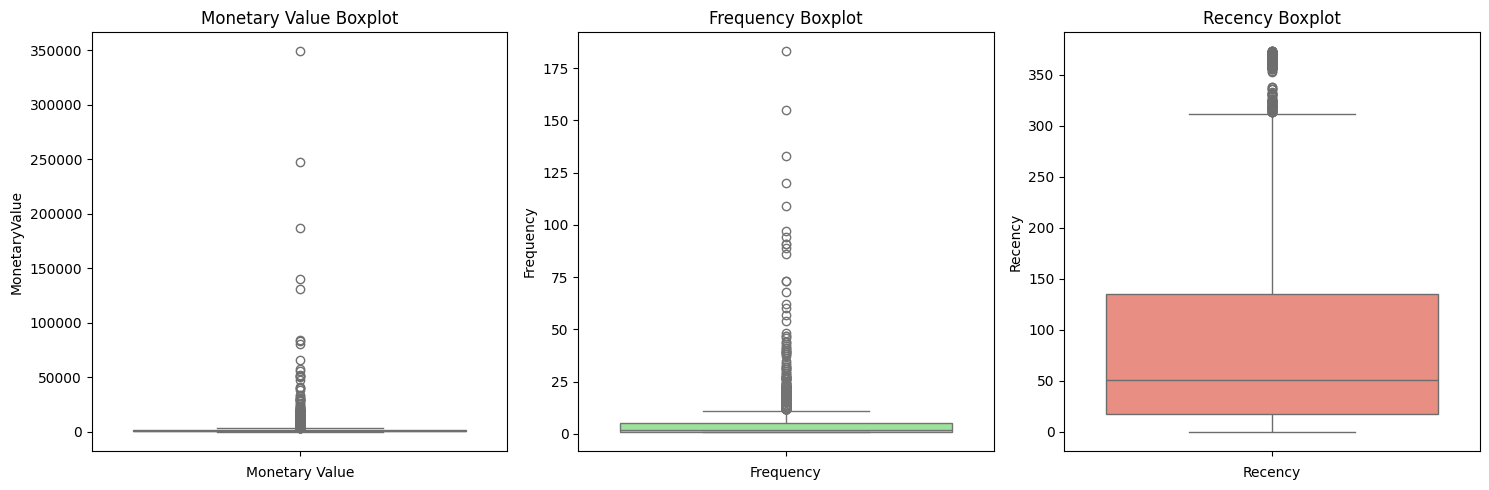

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [14]:
# # Handle outliers
# for col in ["MonetaryValue", "Frequency", "Recency"]:
#     Q1 = aggregated_df[col].quantile(0.25)
#     Q3 = aggregated_df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     aggregated_df = aggregated_df[(aggregated_df[col] >= Q1 - 1.5 * IQR) & (aggregated_df[col] <= Q3 + 1.5 * IQR)]

In [15]:
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25)
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

monetary_outliers_df = aggregated_df[(aggregated_df["MonetaryValue"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["MonetaryValue"] < (M_Q1 - 1.5 * M_IQR))].copy()

monetary_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [16]:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

frequency_outliers_df = aggregated_df[(aggregated_df['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | (aggregated_df['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()

frequency_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


In [17]:
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index))]

non_outliers_df.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


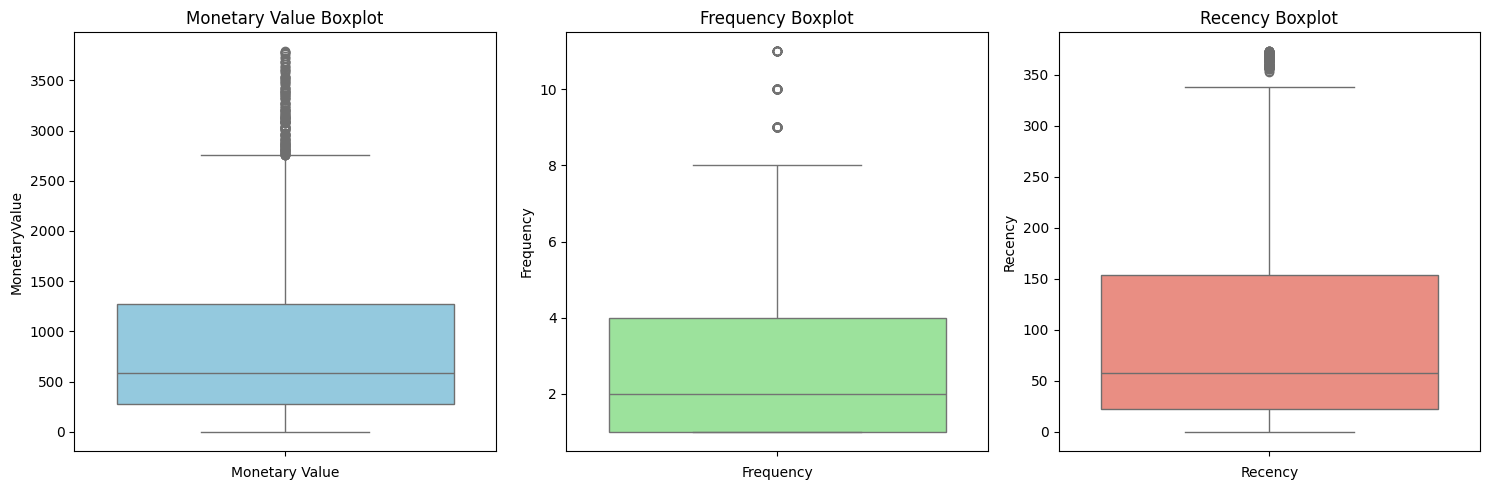

In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

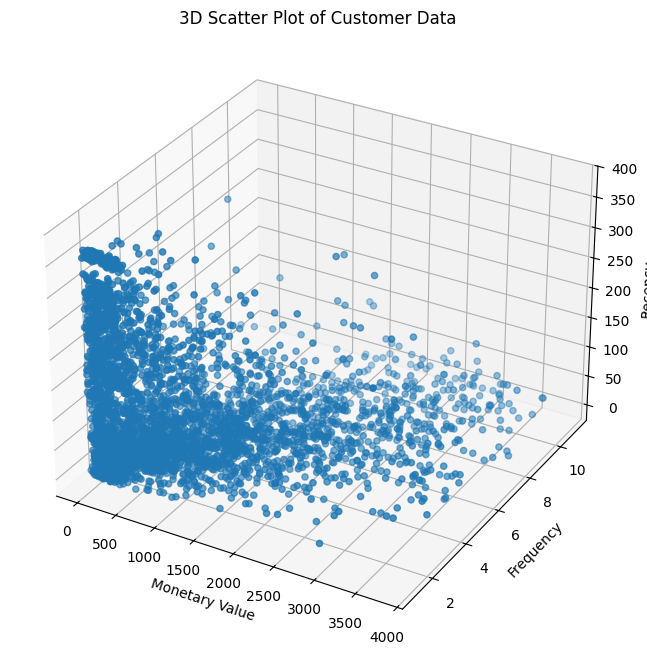

In [19]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

Standard scaling transforms the features of your data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes equally to the analysis.

$$
z = \frac{x - \mu}{\sigma}
$$

Where:
- $z$ is the standardized value,
- $x$ is the original value,
- $\mu$ is the mean of the feature,
- $\sigma$ is the standard deviation of the feature.

In [20]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])

scaled_data

array([[-0.87594534, -0.38488934,  0.68214853],
       [ 0.5355144 , -0.38488934, -0.96925093],
       [-0.81258645, -0.83063076, -0.24548944],
       ...,
       [-0.62197163, -0.83063076,  2.01753946],
       [ 0.44146683, -0.38488934,  0.14187587],
       [ 1.72488781,  0.50659348, -0.81634357]])

In [21]:
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=("MonetaryValue", "Frequency", "Recency"))

scaled_data_df

,MonetaryValue,Frequency,Recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


## KMeans Clustering

In [22]:
# Elbow method and silhouette score
max_k = 12
inertia = []
silhouette_scores = []

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data_df, cluster_labels))

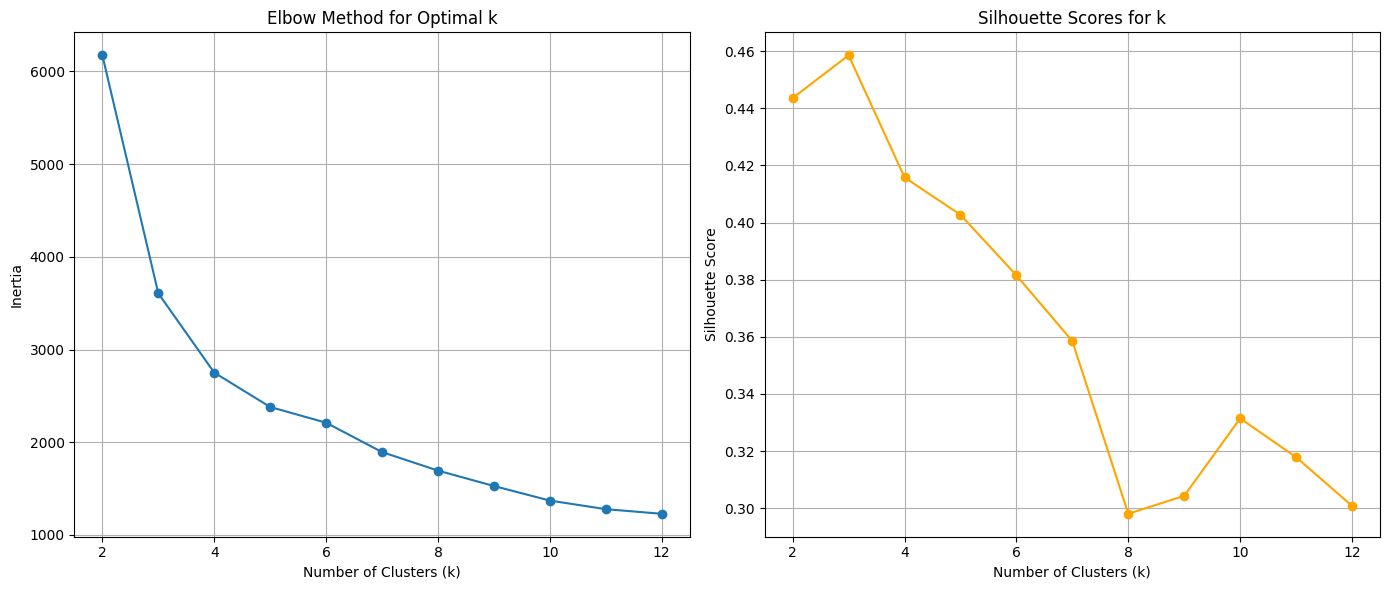

In [23]:
# Plot elbow and silhouette score
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores for k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

### Silhouette Score

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

Where:
- $s(i)$ is the silhouette score for a single sample $i$
- $a(i)$ is the average distance between $i$ and all other points in the same cluster,
- $b(i)$ is the minimum average distance between $i$ and all points in the nearest cluster to which $i$ does not belong.

The silhoutte score ranges between $[-1, 1]$, a higher value indicates more distinct clusters.

In [24]:
# Fit optimal KMeans
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, max_iter=1000)
non_outliers_df["Cluster"] = kmeans.fit_predict(scaled_data_df)
non_outliers_df

C:\Users\viraj\AppData\Local\Temp\ipykernel_29160\2197151536.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = kmeans.fit_predict(scaled_data_df)


,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17,0
4281,18284.00,411.68,1,2010-10-04 11:33:00,66,2
4282,18285.00,377.00,1,2010-02-17 10:24:00,295,1
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111,0


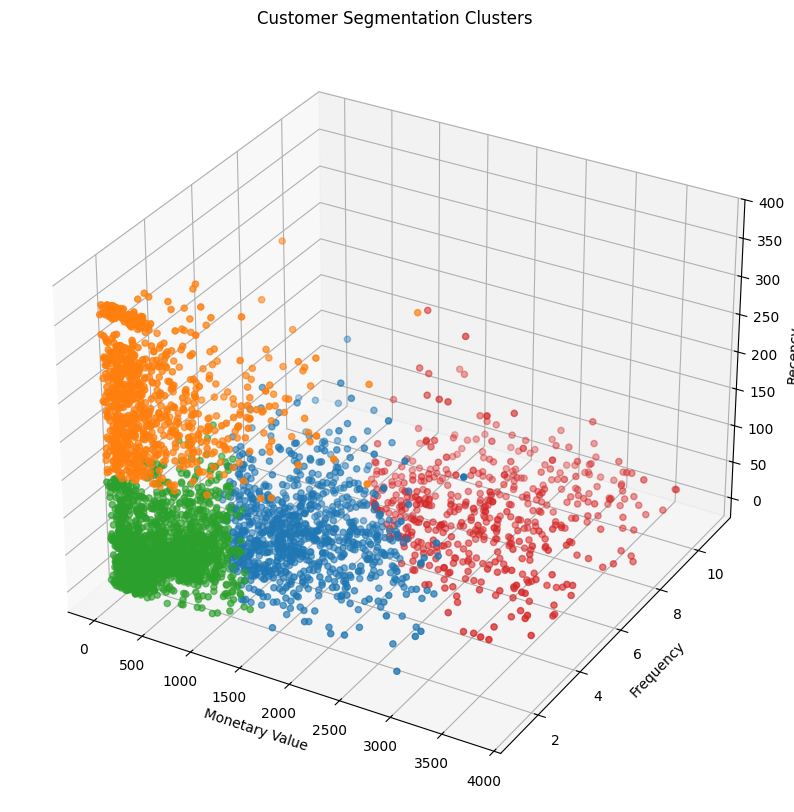

In [25]:
# Visualize clusters
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['MonetaryValue'], 
                     non_outliers_df['Frequency'], 
                     non_outliers_df['Recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('Customer Segmentation Clusters')

plt.show()

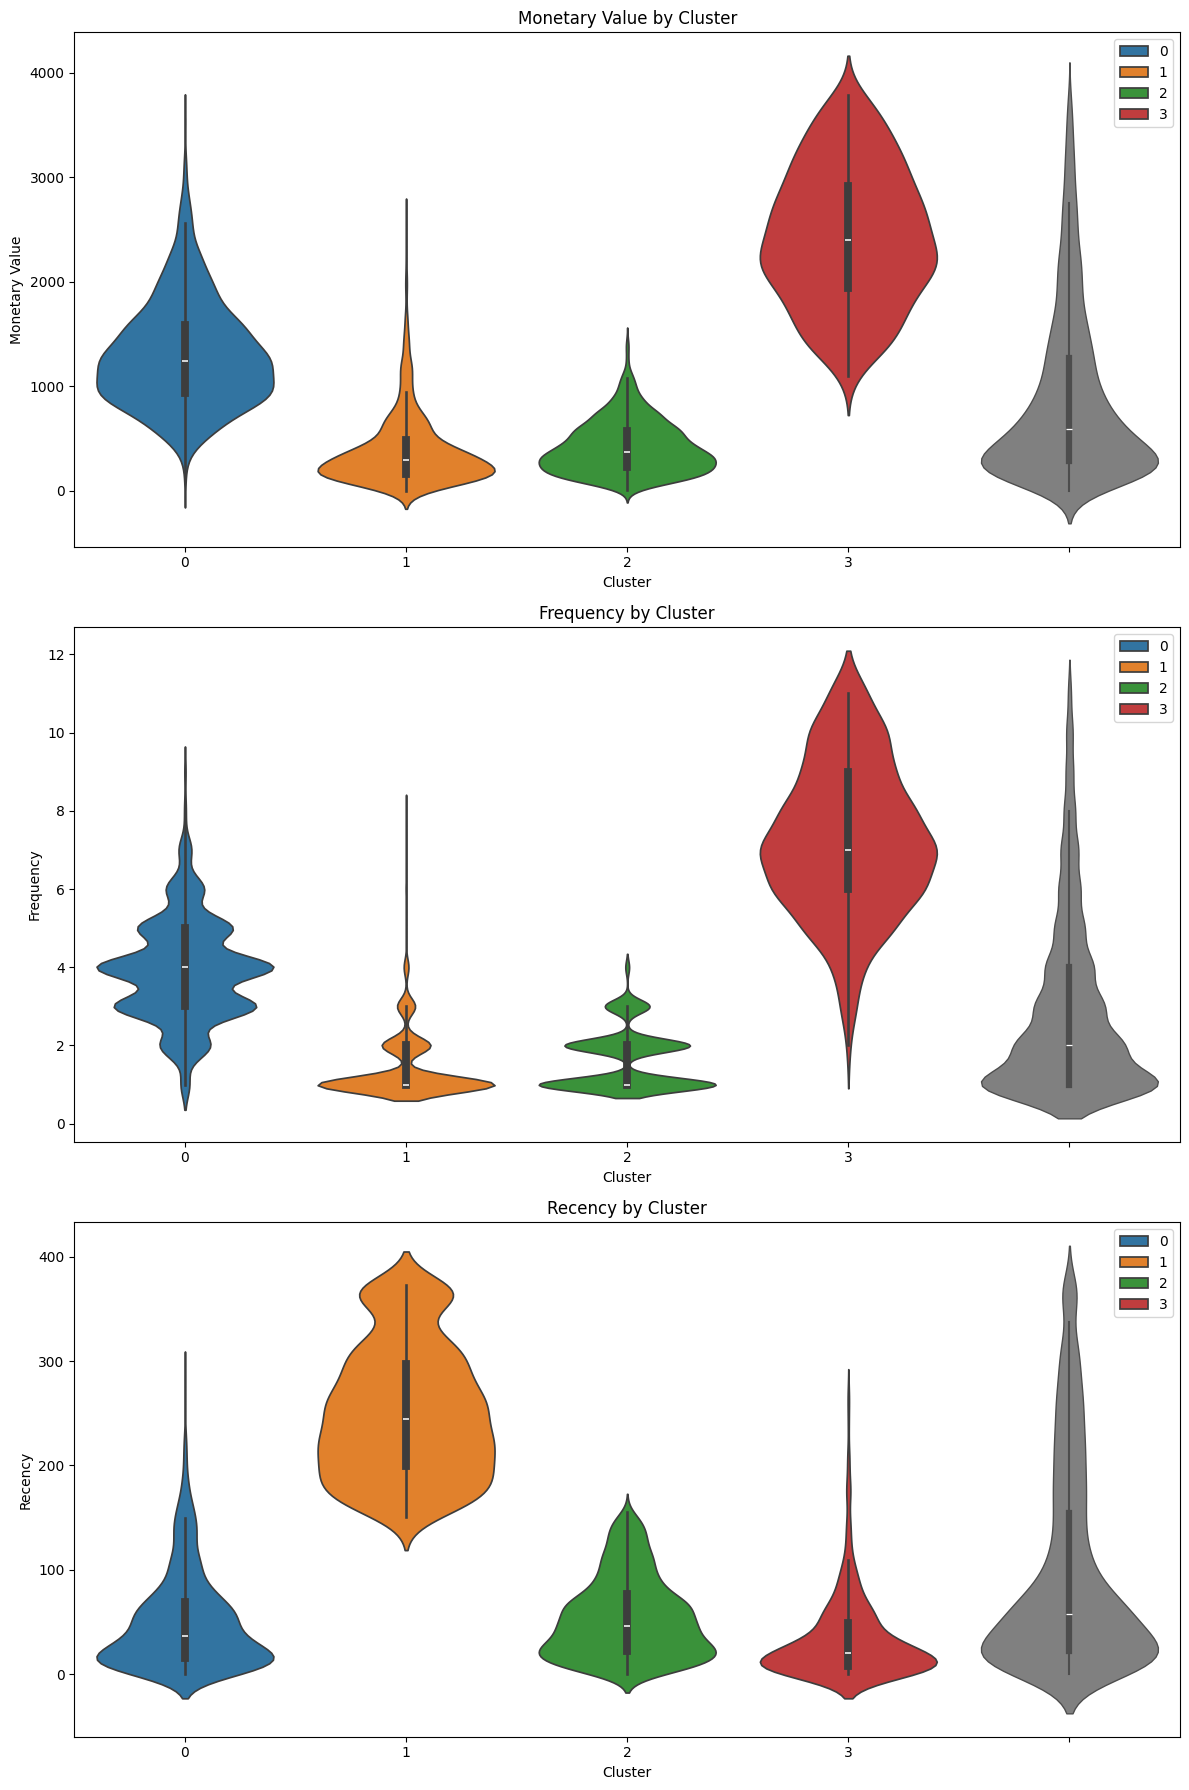

In [26]:
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['MonetaryValue'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')


plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

1. Cluster 0 (Blue): "Retain"
* Rationale: This cluster represents high-value customers who purchase regularly, though not always very recently. The focus should be on retention efforts to maintain their loyalty and spending levels.
* Action: Implement loyalty programs, personalized offers, and regular engagement to ensure they remain active.

2. Cluster 1 (Orange): "Re-Engage"
* Rationale: This group includes lower-value, infrequent buyers who haven’t purchased recently. The focus should be on re-engagement to bring them back into active purchasing behavior.
* Action: Use targeted marketing campaigns, special discounts, or reminders to encourage them to return and purchase again.

3. Cluster 2 (Green): "Nurture"
* Rationale: This cluster represents the least active and lowest-value customers, but they have made recent purchases. These customers may be new or need nurturing to increase their engagement and spending.
* Action: Focus on building relationships, providing excellent customer service, and offering incentives to encourage more frequent purchases.

4. Cluster 3 (Red): "Reward"
* Rationale: This cluster includes high-value, very frequent buyers, many of whom are still actively purchasing. They are your most loyal customers, and rewarding their loyalty is key to maintaining their engagement.
* Action: Implement a robust loyalty program, provide exclusive offers, and recognize their loyalty to keep them engaged and satisfied.

**Summary of Cluster Names:**

* Cluster 0 (Blue): "Retain"
* Cluster 1 (Orange): "Re-Engage"
* Cluster 2 (Green): "Nurture"
* Cluster 3 (Red): "Reward"

In [27]:
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

outlier_clusters_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
9,12357.00,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380.00,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409.00,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415.00,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431.00,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


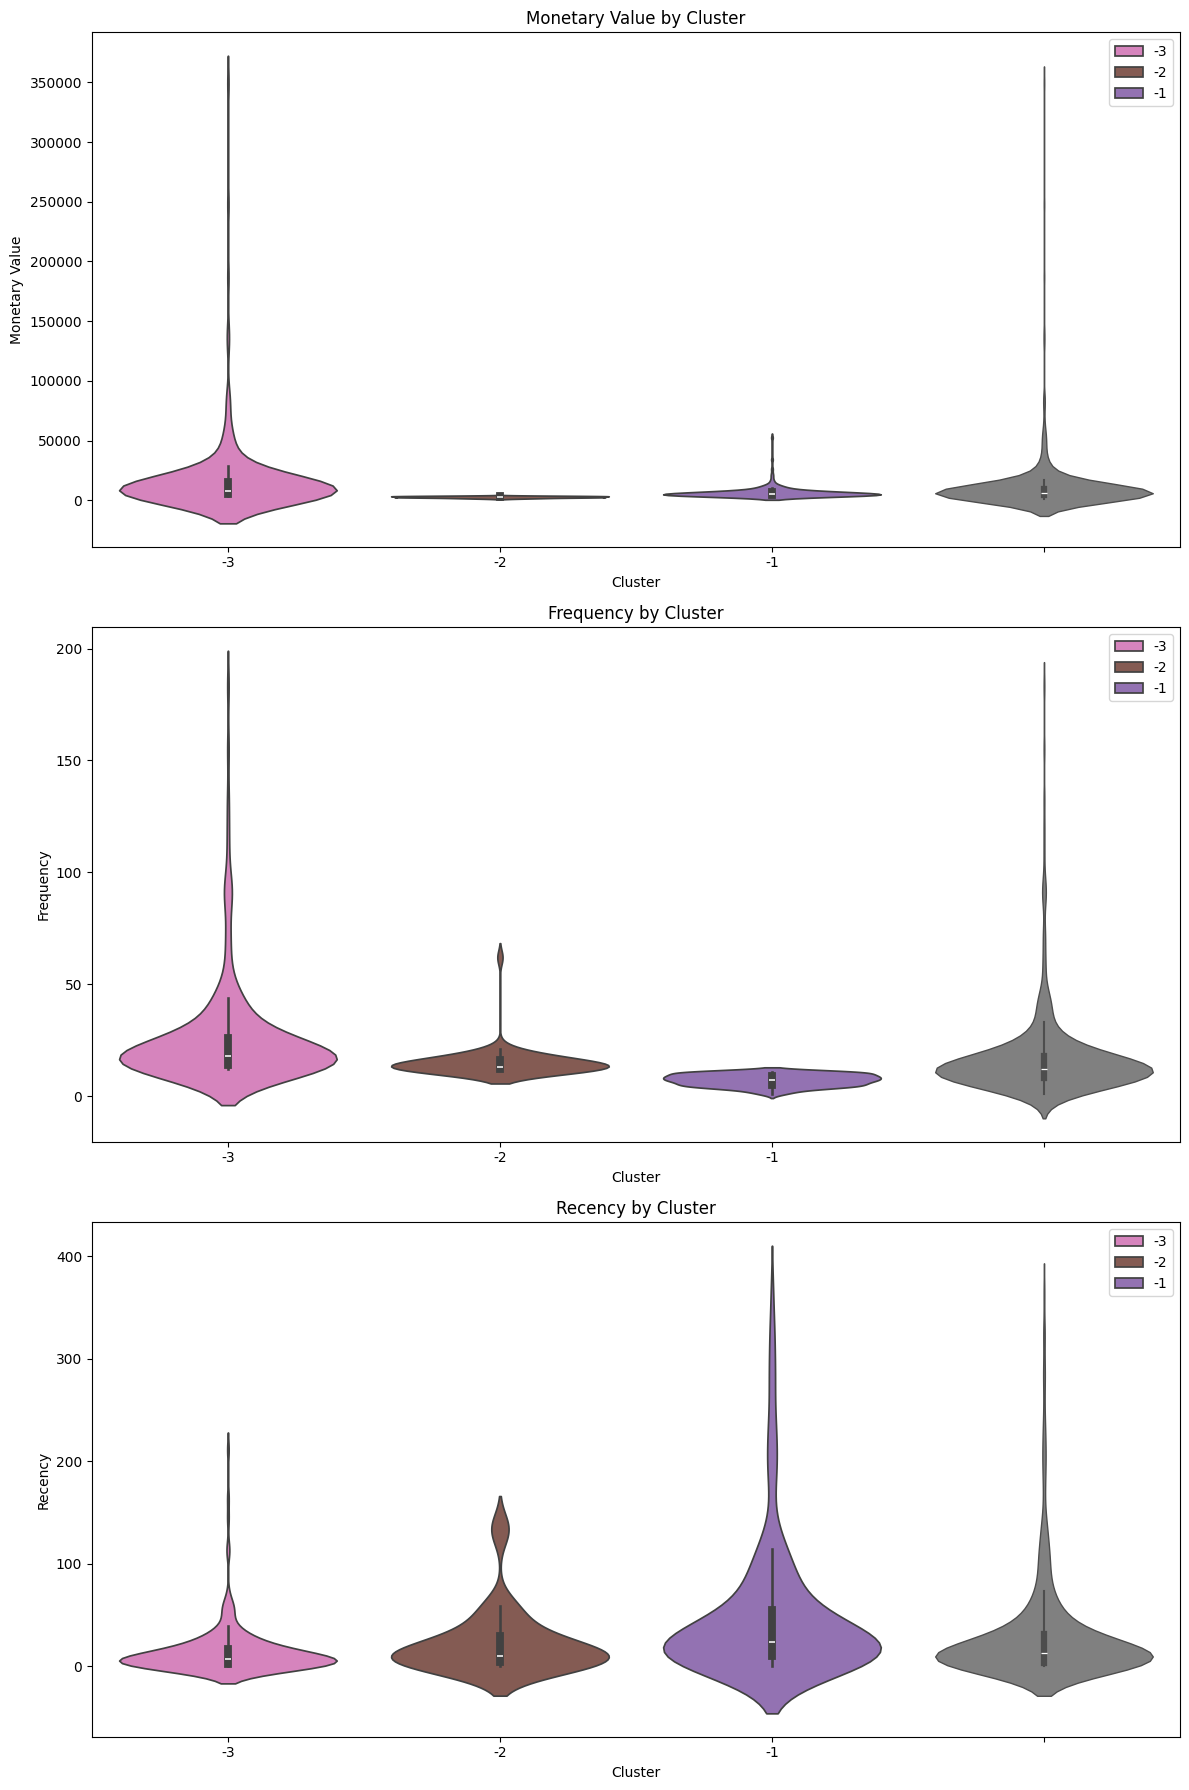

In [28]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['MonetaryValue'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['MonetaryValue'], color='gray', linewidth=1.0)
plt.title('Monetary Value by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray', linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray', linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

* Cluster -1 (Monetary Outliers) PAMPER:
Characteristics: High spenders but not necessarily frequent buyers. Their purchases are large but infrequent.
Potential Strategy: Focus on maintaining their loyalty with personalized offers or luxury services that cater to their high spending capacity.

* Cluster -2 (Frequency Outliers) UPSELL:
Characteristics: Frequent buyers who spend less per purchase. These customers are consistently engaged but might benefit from upselling opportunities.
Potential Strategy: Implement loyalty programs or bundle deals to encourage higher spending per visit, given their frequent engagement.

* Cluster -3 (Monetary & Frequency Outliers) DELIGHT:
Characteristics: The most valuable outliers, with extreme spending and frequent purchases. They are likely your top-tier customers who require special attention.
Potential Strategy: Develop VIP programs or exclusive offers to maintain their loyalty and encourage continued engagement.

In [29]:
cluster_labels = {
    0: "RETAIN",
    1: "RE-ENGAGE",
    2: "NURTURE",
    3: "REWARD",
    -1: "PAMPER",
    -2: "UPSELL",
    -3: "DELIGHT"
}

In [30]:
full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


In [31]:
full_clustering_df["ClusterLabel"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster,ClusterLabel
0,12346.00,169.36,2,2010-06-28 13:53:00,164,1,RE-ENGAGE
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,0,RETAIN
2,12348.00,221.16,1,2010-09-27 14:59:00,73,2,NURTURE
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,0,RETAIN
4,12351.00,300.93,1,2010-11-29 15:23:00,10,2,NURTURE
...,...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3,DELIGHT
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3,DELIGHT
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3,DELIGHT
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3,DELIGHT


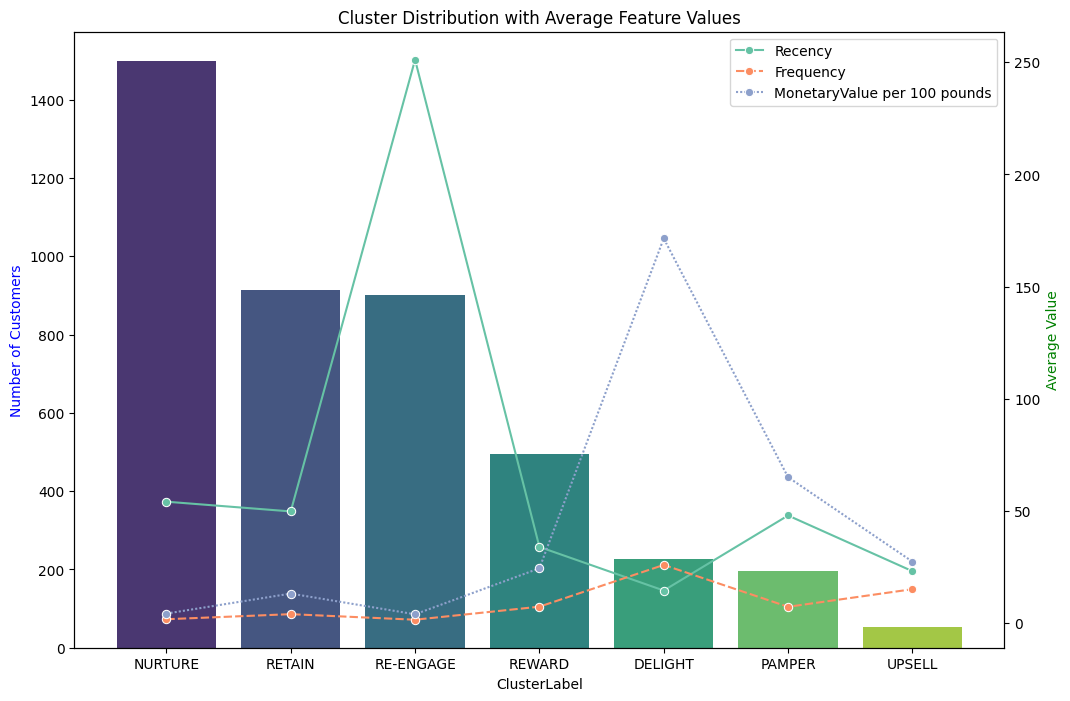

In [32]:
cluster_counts = full_clustering_df['ClusterLabel'].value_counts()
full_clustering_df["MonetaryValue per 100 pounds"] = full_clustering_df["MonetaryValue"] / 100.00
feature_means = full_clustering_df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

In [33]:
# Save cleaned and aggregated data
aggregated_df.to_csv("cleaned_aggregated_customer_data.csv", index=False)

In [35]:
# Summary of clusters
cluster_summary = full_clustering_df.groupby("Cluster").agg(
    Avg_MonetaryValue=("MonetaryValue", "mean"),
    Avg_Frequency=("Frequency", "mean"),
    Avg_Recency=("Recency", "mean"),
    Count=("Cluster", "size")
)
print("\nCluster Summary:\n", cluster_summary)


Cluster Summary:
            Avg_MonetaryValue        Avg_Frequency          Avg_Recency  Count
Cluster                                                                      
-3                  17147.66                25.87                14.45    226
-2                   2734.69                15.04                23.08     53
-1                   6498.45                 7.19                47.91    197
 0                   1308.62                 3.91                49.73    914
 1                    384.54                 1.43               251.17    902
 2                    417.95                 1.64                54.07   1499
 3                   2436.09                 7.24                33.89    494


In [36]:
# Export cluster summary
cluster_summary.to_csv("cluster_summary.csv")